In [1]:
import os
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
sys.path.append('..')

In [3]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms.functional import gaussian_blur
torch.jit.script = lambda x: x

import re 
import h5py
from glob import glob
from functools import partial
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from scipy.spatial.distance import pdist, cdist
from scipy import stats

from hpst.trainers.singleton_point_set_trainer import PointSetTrainer
from hpst.dataset.heterogenous_sparse_sim_dataset import HeterogenousSparseDataset
from hpst.utils.options import Options

# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import cmasher as cmr
import seaborn as sb

In [4]:
CUDA = True
CUDA_DEVICE = 0
USE_TEX = False
TESTING_FILE = None

# TESTING_SOURCE = "interpretation"
# GRADIENT = False

# TESTING_SOURCE = "production"
# GRADIENT = False

TESTING_SOURCE= "testing"
GRADIENT = False

NETWORK = PointSetTrainer

In [5]:
TESTING_FILE = "/home/roblesee/dune/hpst/data/sim_data/test"
BASE_DIRECTORY =  "../results/hpst/lightning_logs/version_203"
CHECKPOINT_PATH = "../results/hpst/lightning_logs/version_203/checkpoints/last.ckpt"

# Load checkpoint and add the test file location
options = Options.load(f"{BASE_DIRECTORY}/options.json")

if TESTING_FILE:
    options.testing_file = TESTING_FILE
else:
    options.testing_file = options.training_file.replace("training", TESTING_SOURCE)
options.num_dataloader_workers = 0

if CHECKPOINT_PATH is None:
    checkpoints = glob(f"{BASE_DIRECTORY}/checkpoints/epoch*.ckpt")
    last_checkpoint = np.argmax([int(re.search("step=(.*).ckpt", s)[1]) for s in checkpoints])
    checkpoint_path = checkpoints[last_checkpoint]
else:
    checkpoint_path = CHECKPOINT_PATH
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint["state_dict"]
print(f"Loading from: {checkpoint_path}")

network = NETWORK(options)
network.load_state_dict(state_dict)

network = network.eval()

if not GRADIENT:
    for parameter in network.parameters():
        parameter.requires_grad_(False)

if CUDA:
    network = network.cuda(CUDA_DEVICE)

/tmp/ipykernel_13968/2612690162.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


Loading from: ../results/hpst/lightning_logs/version_203/checkpoints/last.ckpt
loading training
/baldig/physicsprojects/roblesee/sim_data/train_cache/cache_0.0_0.85.pt


/home/roblesee/dune/hpst/notebooks/../hpst/dataset/heterogenous_sparse_sim_dataset.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache = torch.load(CACHE_FILE)


torch.Size([269276570])
tensor(0) tensor(7)
tensor([ 10821561, 103297288,  33666441,  17460621,  10248095,  43728218,
         47183570,   2870784])
/baldig/physicsprojects/roblesee/sim_data/train_cache/cache_0.85_1.0.pt
torch.Size([48785812])
tensor(0) tensor(7)
tensor([ 1926672, 18950314,  5871999,  3156849,  1817022,  8100520,  8448533,
          513911])
loading testing
/baldig/physicsprojects/roblesee/sim_data/test_cache/cache_0.0_1.0.pt
torch.Size([82857804])
tensor(0) tensor(7)
tensor([ 3330725, 31701870, 10433726,  5273877,  3191052, 13539265, 14581754,
          805543])


In [6]:
DATASET = network.testing_dataset

In [7]:
DATASET.return_index = True

In [8]:
dataloader_options = network.dataloader_options
dataloader_options["pin_memory"] = False
dataloader_options["num_workers"] = 0
dataloader_options["batch_size"] = 128
dataloader_options["drop_last"] = False

test_dataloader = network.dataloader(DATASET, **dataloader_options)

In [9]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

In [10]:
total_coords1 = []
total_coords2 = []

total_predictions1 = []
total_predictions2 = []

total_object_predictions1 = []
total_object_predictions2 = []


total_targets1 = []
total_targets2 = []

total_object_targets1 = []
total_object_targets2 = []

total_raws1 = []
total_raws2 = []

total_batch_idx1 = []
total_batch_idx2 = []

current_batch1 = 0
current_batch2 = 0

num_objects = 10

total_ids = []
for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1 = network.forward(
        features1, coordinates1, batches1
    )
    
    total_ids.append(ids.cpu())
    
    mask1 = ((targets1 != -1))#(object_targets1 < num_objects))
    
    total_coords1.append(coordinates1[mask1].cpu())
    
    total_predictions1.append(predictions1[mask1].argmax(-1).cpu())
    
    total_object_predictions1.append(object_predictions1[mask1].argmax(-1).cpu())
    
    total_targets1.append(targets1[mask1].cpu())
    
    total_object_targets1.append(object_targets1[mask1].cpu())
    
    total_raws1.append(predictions1[mask1].cpu())
    
    total_batch_idx1.append(batches1[mask1].cpu() + current_batch1 + 1)
    current_batch1 += batches1.max().item() + 1
    
total_predictions1 = torch.cat(total_predictions1)
total_targets1 = torch.cat(total_targets1)
total_raws1 = torch.cat(total_raws1)
total_batch_idx1 = torch.cat(total_batch_idx1)
total_coords1 = torch.cat(total_coords1)
total_ids = torch.cat(total_ids)
total_object_predictions1 = torch.cat(total_object_predictions1)
total_object_targets1 = torch.cat(total_object_targets1)

100%|████████████████████████████████████████████████████████████████| 314/314 [01:47<00:00,  2.91it/s]


In [11]:
import matplotlib
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def imshow_segments_convex_hull(coords, targets, segments, ax):
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(100,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=5.5, aspect="equal")
    
    for i in range(10):
        mask = segments == i
        if mask.sum() > 3:
            points = coords[mask].numpy()
            hull = ConvexHull(points=points)
            #convex_hull_plot_2d(hull, ax=ax)
            ax.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)

    
    return im


def imshow_segments(coords, targets, segments, weights, ax):
    
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(100,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=5.5, aspect="equal")
    
    for i in range(10):
        mask = segments == i
        if mask.sum() > 3:
            points = coords[mask].numpy()
            lox = points[:,0].min()-1
            hix = points[:,0].max()+1
            loy = points[:,1].min()-1
            hiy = points[:,1].max()+1
            
            #ax.plot([lox,hix,hix,lox,lox],[loy,loy,hiy,hiy,loy])

    
    return im
    
def plot_results(i):
    mask1 = total_batch_idx1 == i+1
    mask2 = total_batch_idx2 == i+1
    
    coordsx = total_coords1[mask1]
    coordsy = total_coords2[mask2]
    predsx = total_predictions1[mask1]
    predsy = total_predictions2[mask2]
    targetsx = total_targets1[mask1]
    targetsy = total_targets2[mask2]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions2[mask2]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets2[mask2]
    featuresx = total_features1[mask1]
    featuresy = total_features2[mask2]
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.575, 0.025, 0.25])
    
    ax = axs[0][0]
    im = imshow_segments(coordsx, targetsx, objecttargetsx, featuresx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, true label")
    
    ax = axs[0][1]
    im = imshow_segments(coordsy, targetsy, objecttargetsy, featuresy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, true label")
    
    ax = axs[1][0]
    im = imshow_segments(coordsx, predsx, objectpredsx, featuresx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, prediction")
    
    ax = axs[1][1]
    im = imshow_segments(coordsy, predsy, objectpredsy, featuresy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5])
    cbar.ax.set_yticklabels(["Background", "Muon", "Electron", "Proton", "Photon", "Pion"])
    
    fig.suptitle("id: %d, pur: %.02f, eff: %.02f" % (total_ids[i], total_purs[i], total_effs[i]))
    
    plt.show()

In [12]:
plot_results(5)

IndexError: list index out of range

In [ ]:
def idx_to_str(idx):
    if idx < 4:
        return "numuCC"
    if idx < 8:
        return "nueCC"
    if idx < 14:
        return "NC"
    return "Cosmic"

def imshow_labels(coords, targets, ax):
    targets = torch.sparse_coo_tensor(
        coords.T,
        targets,
        size=(160,80)
    ).to_dense()
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=7.5, aspect="equal")
    
    return im

def imshow_objects(coords, targets, ax):
    #vmax = min(targets.amax().item(), 20) + 0.5
    # print(targets.unique())
    targets = torch.sparse_coo_tensor(
        coords.T[:,:],
    (targets+1),
        size=(160,80)
    ).to_dense()
    targets = targets.to(float)
    targets[targets == 0] = torch.nan
    # targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    
    im = ax.imshow(targets.T, cmap="tab20", vmin=-0.5, vmax=20.5, aspect="equal")
    
    return im
    
def plot_results(i):
    #intertype = DATASET.intertype[i]
    intertype = 1
    id_ = total_ids[i].cpu()
    mask1 = total_batch_idx1.cpu() == id_
    #mask2 = total_batch_idx2.cpu() == id_
    
    coordsx = total_coords1[mask1][:,[2,0]] + torch.tensor([[0,40]])
    coordsy = total_coords1[mask1][:,[2,1]] + torch.tensor([[0,40]])
    predsx = total_predictions1[mask1]
    predsy = total_predictions1[mask1]
    targetsx = total_targets1[mask1]
    targetsy = total_targets1[mask1]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions1[mask1]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets1[mask1]
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40,12))
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    
    ax = axs[0][0]
    im = imshow_labels(coordsx, targetsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, true label")
    
    ax = axs[0][1]
    im = imshow_labels(coordsy, targetsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, true label")
    
    ax = axs[0][2]
    im = imshow_labels(coordsx, predsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, prediction")
    
    ax = axs[0][3]
    im = imshow_labels(coordsy, predsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5,6,7])
    cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
    
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.25])
    
    ax = axs[1][0]
    im = imshow_objects(coordsx, objecttargetsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, segmentation true label")
    
    ax = axs[1][1]
    im = imshow_objects(coordsy, objecttargetsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, segmentation true label")
    
    ax = axs[1][2]
    im = imshow_objects(coordsx, objectpredsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, segmentation prediction")
    
    ax = axs[1][3]
    im = imshow_objects(coordsy, objectpredsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, segmentation prediction")
    
    cbar = fig.colorbar(im, cax=cbar_ax)
    
    
    
    fig.suptitle("i: %d, id: %d, type: %s" % (i, total_ids[i], idx_to_str(intertype)))
    
    plt.show()
    #plt.savefig("/baldig/physicsprojects/roblesee/neutrino_viz_paper/%d.png" % total_ids[i]);
    plt.close();

In [ ]:
plot_results(110)

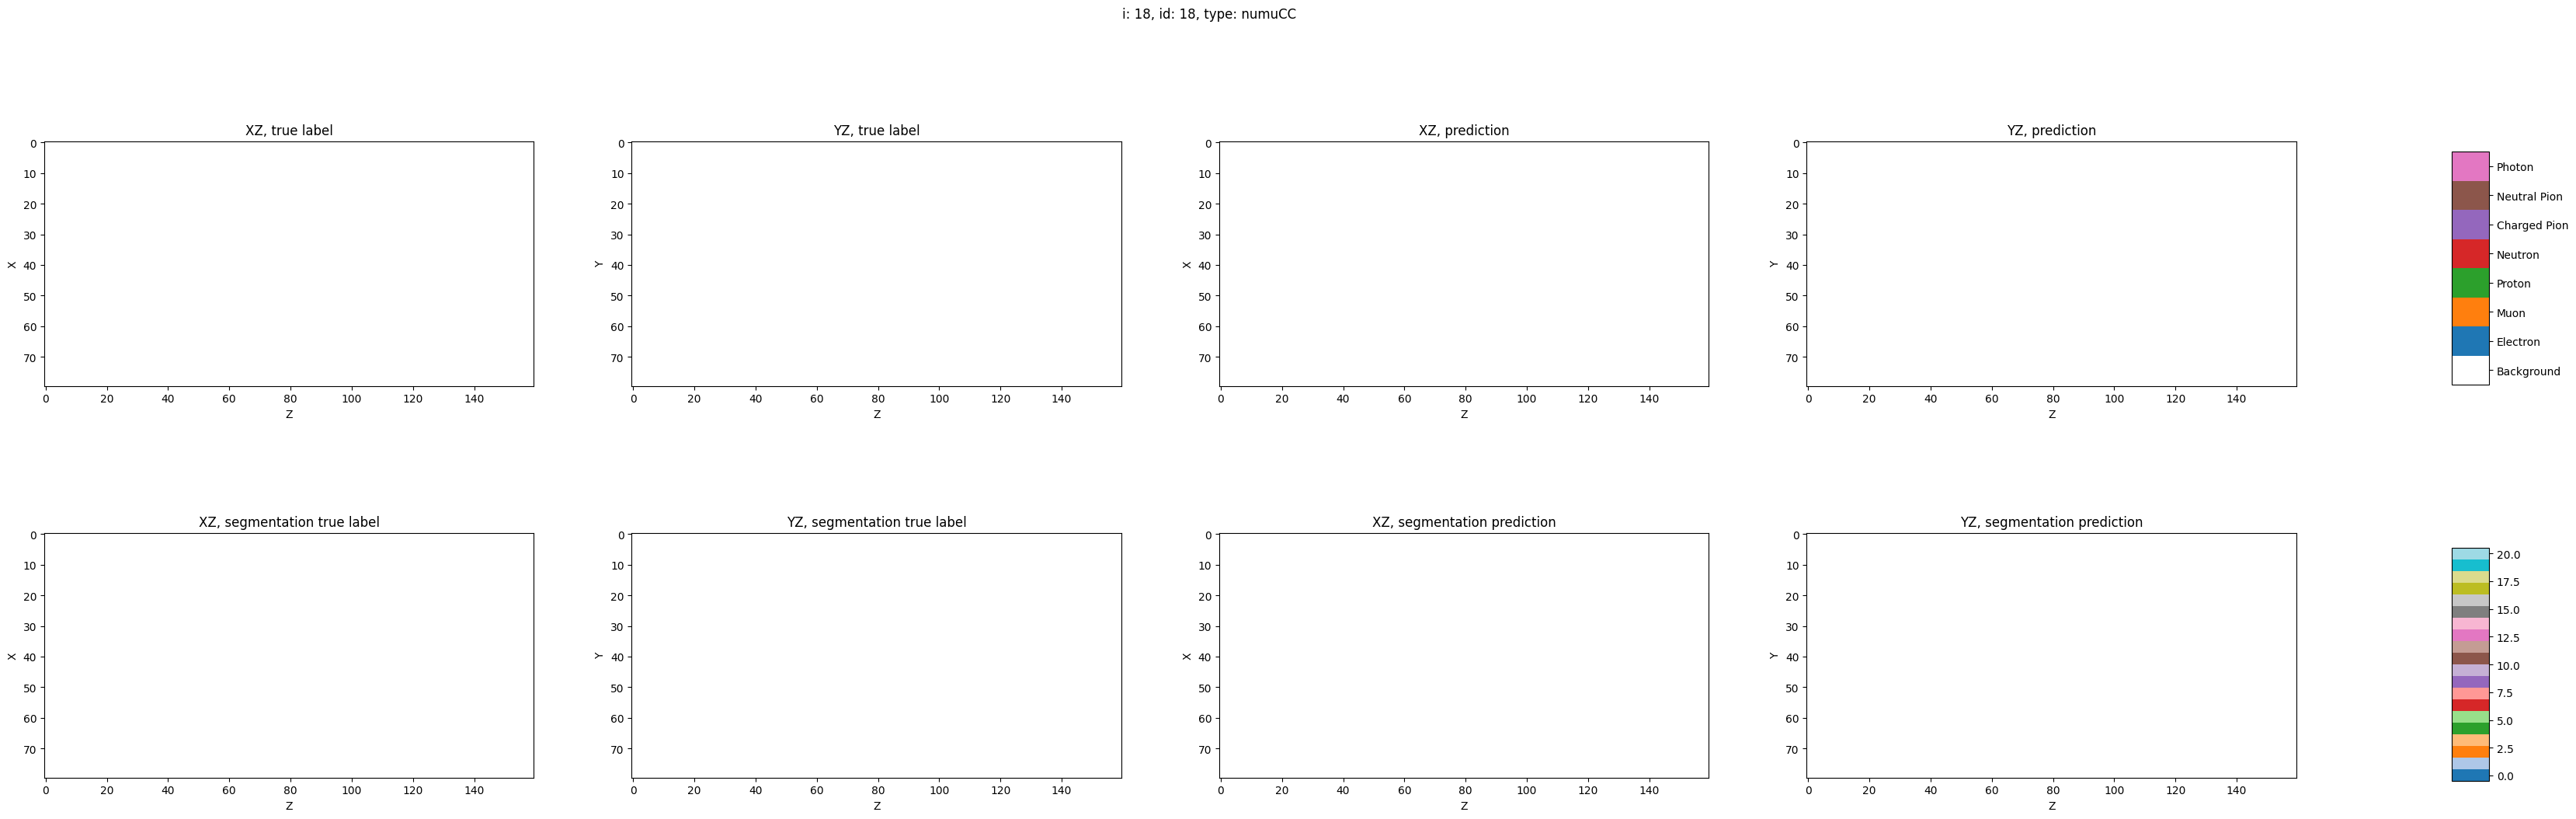

In [15]:
plot_results(18)

In [16]:
len(DATASET)

40090

In [ ]:
perm = torch.randperm(total_ids.shape[0])

ids = perm[:10000]

In [ ]:
for id_ in tqdm(ids):
    plot_results(id_)

In [13]:
def idx_to_str(idx):
    if idx < 4:
        return "numuCC"
    if idx < 8:
        return "nueCC"
    if idx < 14:
        return "NC"
    return "Cosmic"

def imshow_labels(coords, input_targets, ax):
    resolution = coords.amax(axis=0).to(int) + 1
    #print(resolution)
    #print(targets.min(), targets.max())
    #targets = torch.sparse_coo_tensor(
    #    coords.T,
    #    targets,
    #    size=(resolution[0].item(),resolution[1].item())
    #).to_dense()
    print(input_targets.shape)
    targets = torch.zeros((resolution[0].item(),resolution[1].item()), dtype=input_targets.dtype)
    coords = coords.to(int)
    targets[coords[:,0], coords[:,1]] = input_targets + 1
    
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
    im = ax.imshow(targets.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5, aspect="equal")
    
    return im

def imshow_objects(coords, targets, ax):
    #vmax = min(targets.amax().item(), 20) + 0.5
    # print(targets.unique())
    resolution = coords.amax(axis=0).to(int) + 1
    targets = torch.sparse_coo_tensor(
        coords.T[:,:],
    (targets+1),
        size=(resolution[0].item(),resolution[1].item())
    ).to_dense()
    targets = targets.to(float)
    targets[targets == 0] = torch.nan
    # targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], N=6)
    
    im = ax.imshow(targets.T, cmap="tab20", vmin=-0.5, vmax=20.5, aspect="equal")
    
    return im

def plot_one(i, axs):
    #intertype = DATASET.intertype[i]
    intertype = 1
    id_ = i #total_ids[i].cpu()
    mask1 = total_batch_idx1.cpu() == i
    #mask2 = total_batch_idx2.cpu() == id_
    
    coordsx = total_coords1[mask1][:,[2,0]]
    coordsy = total_coords1[mask1][:,[2,1]]
    predsx = total_predictions1[mask1]
    predsy = total_predictions1[mask1]
    targetsx = total_targets1[mask1]
    targetsy = total_targets1[mask1]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions1[mask1]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets1[mask1]

    print(min(targetsx.min(), targetsy.min()), max(targetsx.max(), targetsy.max()))
    
    coordsx = coordsx - coordsx.amin(axis=0, keepdims=True)
    coordsy = coordsy - coordsy.amin(axis=0, keepdims=True)
    
    newtargetsx = objecttargetsx.clone()
    for i in range(objecttargetsx.max()):
        if (targetsx[objecttargetsx == i].shape[0]) > 0:
            newtargetsx[objecttargetsx == i] = targetsx[objecttargetsx == i].mode().values
            
    newtargetsy = objecttargetsy.clone()
    for i in range(objecttargetsy.max()):
        if (targetsy[objecttargetsy == i].shape[0]) > 0:
            newtargetsy[objecttargetsy == i] = targetsy[objecttargetsy == i].mode().values

    newtargetsx = targetsx
    newtargetsy = targetsy

    fontsize = 9
    
    ax = axs[0][0]
    im = imshow_labels(coordsx, newtargetsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, true label, sample %d" % id_, fontsize=fontsize)
    
    ax = axs[0][1]
    im = imshow_labels(coordsy, newtargetsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, true label, sample %d" % id_, fontsize=fontsize)
    
    ax = axs[1][0]
    im = imshow_labels(coordsx, predsx, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("X")
    ax.set_title("XZ, prediction, sample %d" % id_, fontsize=fontsize)
    
    ax = axs[1][1]
    im = imshow_labels(coordsy, predsy, ax)
    ax.set_xlabel("Z")
    ax.set_ylabel("Y")
    ax.set_title("YZ, prediction, sample %d" % id_, fontsize=fontsize)
    
    return im
    
def plot_results(i, j):
    figwidth = 10
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(figwidth,figwidth/2))

    im = plot_one(i, axs[:,0:2])
    plot_one(j, axs[:,2:4])

    plt.tight_layout()

    fig.subplots_adjust(right=0.85)
    #cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.675])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5,6,7,8])
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    
    #cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.25])
    
    #cbar = fig.colorbar(im, cax=cbar_ax)
    
    #fig.suptitle("i: %d, id: %d, type: %s, pur: %.02f, eff: %.02f" % (i, total_ids[i], idx_to_str(intertype), total_purs[i], total_effs[i]))
    
    #plt.show()
    #plt.savefig("/baldig/physicsprojects/roblesee/neutrino_viz_paper/%d.png" % total_ids[i]);

    #plt.savefig("tracks.pdf")
    plt.savefig("tracks.pdf", format="pdf", bbox_inches="tight", dpi=2400)
    #plt.close();

tensor(0) tensor(5)
torch.Size([1080])
torch.Size([1080])
torch.Size([1080])
torch.Size([1080])
tensor(1) tensor(5)
torch.Size([5960])
torch.Size([5960])
torch.Size([5960])
torch.Size([5960])


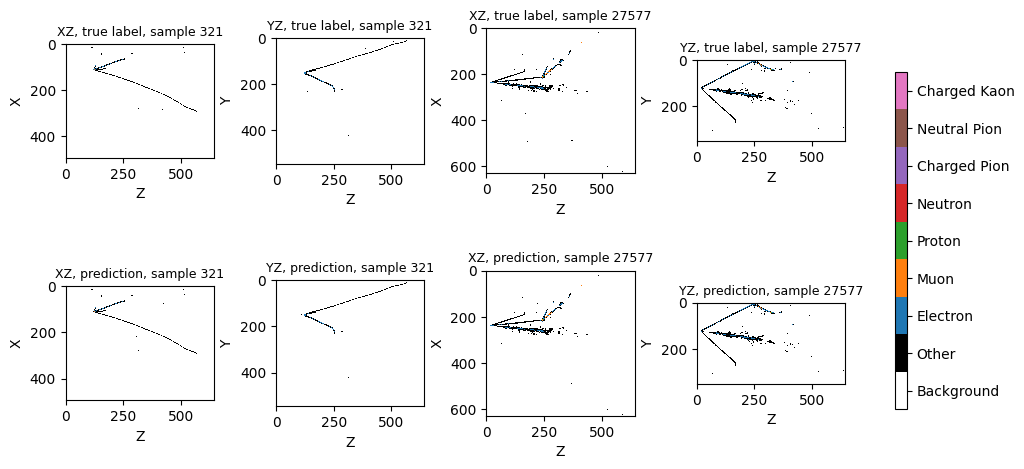

In [65]:
plot_results(321, 27577)

In [ ]:
for i in range(10):
    plot_results(17540+2*i, 17540+(2*i+1))

In [22]:
def plot_single(i):
    figwidth = 100
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(figwidth,figwidth+4))

    im = plot_one(i, axs[:,:])

    plt.tight_layout()

    fig.subplots_adjust(right=0.85)
    #cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.675])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5,6,7,8])
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    plt.show()

In [66]:
plot_single(321)

tensor(0) tensor(5)
torch.Size([1080])
torch.Size([1080])
torch.Size([1080])
torch.Size([1080])


In [123]:
def plot_3d(i, ax):
    #intertype = DATASET.intertype[i]
    intertype = 1
    id_ = i #total_ids[i].cpu()
    mask1 = total_batch_idx1.cpu() == i
    #mask2 = total_batch_idx2.cpu() == id_
    
    coordsx = total_coords1[mask1][:,0]
    coordsy = total_coords1[mask1][:,1]
    coordsz = total_coords1[mask1][:,2]
    predsx = total_predictions1[mask1]
    predsy = total_predictions1[mask1]
    targetsx = total_targets1[mask1]
    targetsy = total_targets1[mask1]
    objectpredsx = total_object_predictions1[mask1]
    objectpredsy = total_object_predictions1[mask1]
    objecttargetsx = total_object_targets1[mask1]
    objecttargetsy = total_object_targets1[mask1]

    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
    im = ax.scatter(coordsx, coordsz, coordsy, c=targetsx+1, s=1, alpha=1, cmap=targets_cmap, marker='o', vmin=-0.5, vmax=8.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    return im

def plot_single_3d(i):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    im = plot_3d(i, ax)

    #plt.tight_layout()
    plt.title(f"Sample {i}, 3D view")

    fig.subplots_adjust(right=0.85)
    #cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.675])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5,6,7,8])
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    plt.show()

def plot_2_3d(i, j):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121, projection='3d')
    
    im = plot_3d(i, ax)
    ax.set_title(f"Sample {i}, 3D view")

    ax = fig.add_subplot(122, projection='3d')
    im = plot_3d(j, ax)
    ax.set_title(f"Sample {j}, 3D view")

    #plt.tight_layout()
    plt.title(f"Sample {i}, 3D view")

    fig.subplots_adjust(right=0.85)
    #cbar_ax = fig.add_axes([0.9, 0.575, 0.012, 0.25])
    cbar_ax = fig.add_axes([0.9, 0.15, 0.012, 0.675])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5,6,7,8])
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    #plt.show()
    plt.savefig("plot3d.pdf", format="pdf", bbox_inches="tight")

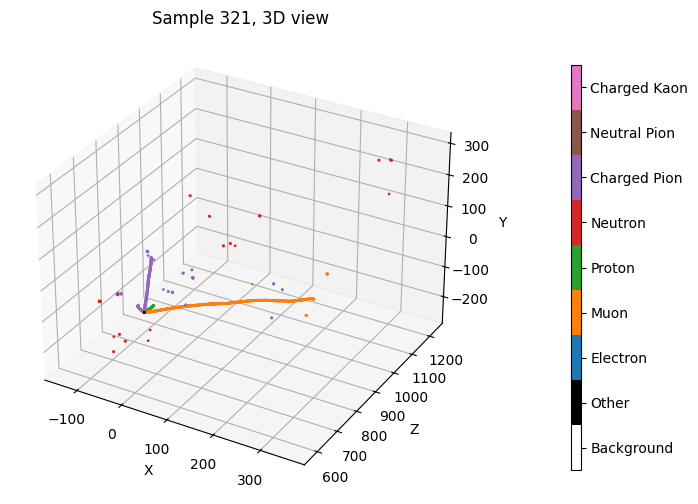

In [121]:
plot_single_3d(321)

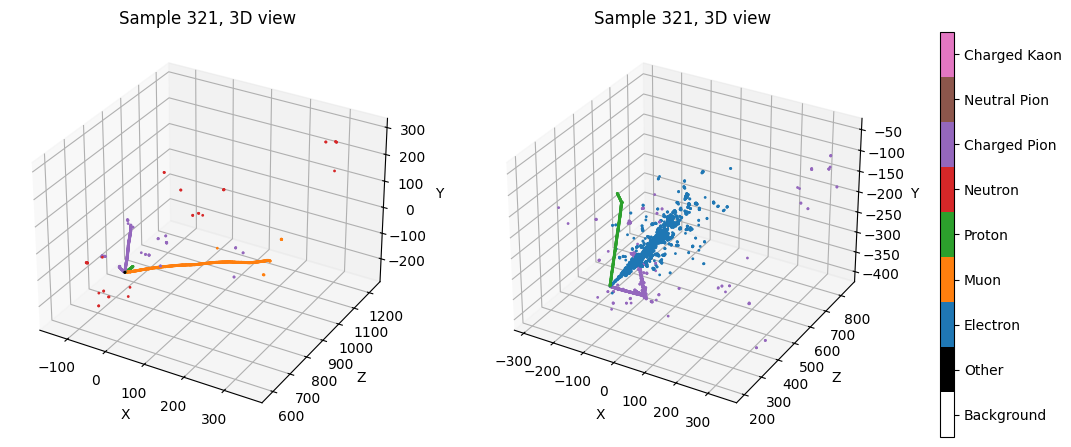

In [124]:
plot_2_3d(321, 27577)